# Model Evaluation

The aim of this notebook is to evaluate the proposed modeling pipeline in terms of segmentation precision (quality) and segmentation time (performance). The models under evaluation are listed next:
1. **SegFormer1 (baseline)**: This model is based on Transformers and has been taken from https://learnopencv.com/medical-image-segmentation/. The model has been trained using only segmented images. SegFormer1 is our baseline for comparison purposes.
2. **ResNetClassifier1 + SegFormer1**: In this approach, a binary classifier is employed prior to segmentation. This classifier determines whether a given slice contains any of the organs of interest —namely, the stomach, small bowel, or large bowel— assigning a label of "1" if present, or "0" if absent. The classifier uses the pre-trained convolutional layers of the ResNet50V2 network architecture, with two additional task-specific layers appended at the end: a fully connected layer with 256 neurons, followed by an output sigmoid layer. If the classifier identifies the presence of any of the organs of interest in the input image, the segmentation module is subsequently activated.

<br>
<div align="center">
<img src="../images/model_workflow.png" width="550" class="center">
</div>
<br>

3. **ResNetClassifier2 + SegFormer1**: Similar to model #2. The difference is that the classifier has been trained with a bigger batch size.
4. **SegFormer2**: This model shares the same architecture as SegFormer1. SegFormer2 has been trained using both segmented and non-segmented slices.
5. **ResNetClassifier1 + SegFormer2**: Similar to model #2, except that the segmentation model is SegFormer2.
6. **ResNetClassifier2 + SegFormer2**: Similar to model #3, except that the segmentation model is SegFormer2.

The evaluation metrics are:
* **Dice coefficient**: It measures the spatial overlap between two segmentations. It is given by:
$$
DC = \frac{2 \times |A \cap B|}{|A| + |B|}
$$
Where A and B are the masks associated with the ground truth and prediction, respectively. For multiclass segmentation, the coefficient is computed separately for each class, and then the results are averaged.
* **Segmentation time**: The segmentation time refers to the duration, in seconds, from when an image is inputted into the model to when the corresponding mask is generated.

# Authors
Tina Mangum, Ali Rahjouei, Sergio Sanz, Di Walsh

# Import Libraries

In [1]:
import os
import zipfile
import platform
import warnings
import time
from glob import glob
from dataclasses import dataclass

# To filter UserWarning.
warnings.filterwarnings("ignore", category=UserWarning)

import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt

# Importing torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# For data augmentation and preprocessing
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Imports required SegFormer classes
from transformers import SegformerForSemanticSegmentation

# Importing lighting along with a built-in callback it provides.
import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

# Importing torchmetrics modular and functional implementations.
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassF1Score
from torch.utils.data import Dataset, DataLoader

# To print model summary.
#from torchinfo import summary

# Tensor and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

C:\Users\ssre_\.venv_common\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Sets the internal precision of float32 matrix multiplications.
torch.set_float32_matmul_precision('high')

# To enable determinism.
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# To render the matplotlib figure in the notebook.
%matplotlib inline

In [3]:
ROOT_PATH = "evaluation_data"
MODEL_PATH = "models"
CLASS_MODEL1 = "resnet50v2_nn256_lr0001_relu_batch32_epoch30_v2.keras"
CLASS_MODEL2 = "resnet50v2_nn256_lr0001_relu_batch64_epoch30_v4.keras"
SEG_MODEL_SLC = "ckpt_049-vloss_0.3115_vf1_0.9401_batch16.ckpt"
SEG_MODEL_ALL = "ckpt_049-vloss_0.5816_vf1_0.8927_batch12.ckpt"

# Configuration Class Definition

Let's define first some configuration classes including image-related and preprocessing parameters, and model hyperparameters.

In [4]:
# A class that holds all the hyperparameters we will use to process images.
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:   int = 4 # including background.
    IMAGE_SIZE: tuple[int,int] = (288, 288) # W, H
    MEAN: tuple = (0.485, 0.456, 0.406)
    STD:  tuple = (0.229, 0.224, 0.225)
    MEAN_CLF: float = 0.136
    STD_CLF: float = 0.178
    BACKGROUND_CLS_ID: int = 0
    URL: str = r"https://www.dropbox.com/scl/fi/r0685arupp33sy31qhros/dataset_UWM_GI_Tract_train_valid.zip?rlkey=w4ga9ysfiuz8vqbbywk0rdnjw&dl=1"
    DATASET_PATH: str = os.path.join(os.getcwd(), ROOT_PATH)
    MODEL_NAME_CLF1 = os.path.join(MODEL_PATH, CLASS_MODEL1)
    MODEL_NAME_CLF2 = os.path.join(MODEL_PATH, CLASS_MODEL2)
    MODEL_NAME_SEG_SLC = os.path.join(MODEL_PATH, SEG_MODEL_SLC)
    MODEL_NAME_SEG_ALL = os.path.join(MODEL_PATH, SEG_MODEL_ALL)
    THR1: float = 0.019938506186008453
    THR2: float = 0.07652711868286133

# A class containing the locations of the images and masks of these model evaluation tests
@dataclass(frozen=True)
class Paths:
    DATA_VALID_IMAGES: str = os.path.join(DatasetConfig.DATASET_PATH, "test", "images", r"*.png")
    DATA_VALID_LABELS: str = os.path.join(DatasetConfig.DATASET_PATH, "test", "masks",  r"*.png")

# A class that holds all the hyperparameters for training and evaluation.
@dataclass
class TrainingConfig:
    BATCH_SIZE:      int = 12 # 8
    NUM_EPOCHS:      int = 1
    INIT_LR:       float = 3e-4
    NUM_WORKERS:     int = 0 if platform.system() == "Windows" else os.cpu_count()

    OPTIMIZER_NAME:  str = "AdamW"
    WEIGHT_DECAY:  float = 1e-4
    USE_SCHEDULER:  bool = True # Use learning rate scheduler?
    SCHEDULER:       str = "MultiStepLR" # Name of the scheduler to use.
    MODEL_NAME:str = "nvidia/segformer-b4-finetuned-ade-512-512"

# A class that contains the (optional) batch size and the number of batches to be used to display for inference results.
#@dataclass
class InferenceConfig:
    BATCH_SIZE:  int = 10
    NUM_BATCHES: int = 2

DatasetConfig.NUM_CLASSES = 4

# Class Definition

This section describes a custom class called MedicalDataset for creating training and validation (segmentation) dataset objects.

In [5]:
# Class inherited from Pytorch Dataset
class MedicalDataset(Dataset):
    # Initialization function
    def __init__(self, *, image_paths, mask_paths, img_size, ds_mean, ds_std, ds_mean_clf, ds_std_clf):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.img_size    = img_size
        self.ds_mean = ds_mean
        self.ds_std = ds_std
        self.ds_mean_clf = ds_mean_clf
        self.ds_std_clf = ds_std_clf
        self.transforms  = self.setup_transforms(mean=self.ds_mean, std=self.ds_std)

    # Calculates the number of images used for training or validation
    def __len__(self):
        return len(self.image_paths)

    # Normalization Function for binary classification (stomach/small/large bowel: yes, no)
    def normalize_classif(self, image):
        image = image / 255.0
        image = (image - self.ds_mean_clf) / self.ds_std_clf
        return image

    # Preprocess transforms - Normalization and converting to PyTorch tensor format (HWC --> CHW).
    def setup_transforms(self, *, mean, std):
        transforms = []        
        transforms.extend([
                A.Normalize(mean=mean, std=std, always_apply=True),
                ToTensorV2(always_apply=True),  # (H, W, C) --> (C, H, W)
        ])
        return A.Compose(transforms)

    # load and resize the image to the specified size.
    # The interpolation method used is nearest-neighbor for the segmentation model.
    def load_file_nearest(self, file_path, depth=0):
        file = cv2.imread(file_path, depth)
        if depth == cv2.IMREAD_COLOR:
            file = file[:, :, ::-1]
        return cv2.resize(file, (self.img_size), interpolation=cv2.INTER_NEAREST)

    # load and resize the image to the specified size.
    # The interpolation method used is linear for the classification model.
    def load_file_linear(self, file_path, depth=0):
        file = cv2.imread(file_path, depth)
        if depth == cv2.IMREAD_COLOR:
            file = file[:, :, ::-1]
        return cv2.resize(file, (self.img_size), interpolation=cv2.INTER_LINEAR)

    def __getitem__(self, index):
        # Load and preprocess image for classification
        image_clf = self.load_file_linear(self.image_paths[index], depth=cv2.IMREAD_COLOR)
        image_clf = self.normalize_classif(image_clf)
        
        # Load and preprocess image and mask file, both for segmentation
        image = self.load_file_nearest(self.image_paths[index], depth=cv2.IMREAD_COLOR)       
        mask  = self.load_file_nearest(self.mask_paths[index],  depth=cv2.IMREAD_GRAYSCALE)        
        transformed = self.transforms(image=image, mask=mask)

        # Return the loeaded images
        image, mask = transformed["image"], transformed["mask"].to(torch.long)        
        return image_clf, image, mask

**Class MedicalSegmentationDataModule**: It helps organize and encapsulate all the data-related operations and logic in a PyTorch project. It acts as a bridge between your data and Lightning’s training pipeline. It is a convenient abstraction that encapsulates data-related operations, promotes code organization, and facilitates seamless integration with other Lightning components for efficient and reproducible deep-learning experiments.

**LightningDataModule**: A data module that encapsulates the five steps involved in data processing in PyTorch: Download / tokenize / process; Clean and (maybe) save to disk; Load inside Dataset; Apply transforms (rotate, tokenize, etc…); Wrap inside a DataLoader.

In [6]:
# Define MedicalSegmentationDataModule
class MedicalSegmentationDataModule(pl.LightningDataModule):
    def __init__(
        self,
        num_classes=10,
        img_size=(384, 384),
        ds_mean=(0.485, 0.456, 0.406),
        ds_std=(0.229, 0.224, 0.225),
        ds_mean_clf=0.136,
        ds_std_clf=0.178,
        batch_size=12,
        num_workers=3,
        pin_memory=False,
        shuffle_validation=False,
    ):
        super().__init__()

        self.num_classes = num_classes
        self.img_size    = img_size
        self.ds_mean     = ds_mean
        self.ds_std      = ds_std
        self.ds_mean_clf = ds_mean_clf
        self.ds_std_clf  = ds_std_clf
        self.batch_size  = batch_size
        self.num_workers = num_workers
        self.pin_memory  = pin_memory
        self.shuffle_validation = shuffle_validation

    # Create validation dataset and dataloader.
    def setup(self, *args, **kwargs):        
        valid_imgs = sorted(glob(f"{Paths.DATA_VALID_IMAGES}"))        
        valid_msks = sorted(glob(f"{Paths.DATA_VALID_LABELS}"))
        self.valid_ds = MedicalDataset(image_paths=valid_imgs, mask_paths=valid_msks, img_size=self.img_size, 
                                       ds_mean=self.ds_mean, ds_std=self.ds_std,
                                       ds_mean_clf=self.ds_mean_clf, ds_std_clf=self.ds_std_clf)

    # Create validation dataloader object.
    def val_dataloader(self):        
        return DataLoader(
            self.valid_ds, batch_size=self.batch_size,  pin_memory=self.pin_memory,
            num_workers=self.num_workers, shuffle=self.shuffle_validation
        )

**Class MedicalSegmentationModel**: This class describes the variables, hyperparameters, and functions associated with the SegFormer segmentation model.

In [7]:
# Loading a pre-trained model version
def get_model(*, model_name, num_classes):
    model = SegformerForSemanticSegmentation.from_pretrained(
        model_name,
        num_labels=num_classes,
        ignore_mismatched_sizes=True,
    )
    return model
    
class MedicalSegmentationModel(pl.LightningModule):
    def __init__(
        self,
        model_name: str,
        num_classes: int = 10,
        init_lr: float = 0.001,
        optimizer_name: str = "Adam",
        weight_decay: float = 1e-4,
        use_scheduler: bool = False,
        scheduler_name: str = "multistep_lr",
        num_epochs: int = 1,
    ):
        super().__init__()

        # Save the arguments as hyperparameters.
        self.save_hyperparameters()

        # Loading model using the function defined above.
        self.model = get_model(model_name=self.hparams.model_name, num_classes=self.hparams.num_classes)

        # Initializing the required metric objects.
        self.mean_train_loss = MeanMetric()
        self.mean_train_f1 = MulticlassF1Score(num_classes=self.hparams.num_classes, average="macro")
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_f1 = MulticlassF1Score(num_classes=self.hparams.num_classes, average="macro")

    def forward(self, data):
        outputs = self.model(pixel_values=data, return_dict=True)
        upsampled_logits = F.interpolate(outputs["logits"], size=data.shape[-2:], mode="bilinear", align_corners=False)
        return upsampled_logits

This section comprises three functions:
* **Dice Coefficient Function**: Computes the Dice coefficient, a measure of spatial overlap, used for evaluating segmentation accuracy.
* **Mask Detection Function**: Detects masks containing any of the segmented organs, a prerequisite for Dice coefficient evaluation.
* **Prediction and Metric Computation Function (Inference)**: Performs inference to make predictions and computes evaluation metrics based on the ground truth and predicted masks.
* **Metrics Printing Function**: Prints out the computed evaluation metrics for analysis and interpretation."Evaluation Functions

In [8]:
# Compute Dice coefficient
def dice_coeff(predictions, ground_truths, num_classes=4, dims=(1, 2), smooth=1e-8):
    # (batch_size, height, width, num_classes)
    ground_truth_oh = F.one_hot(ground_truths, num_classes=num_classes)
    # (batch_size, height, width, num_classes)
    prediction_norm = F.one_hot(predictions, num_classes=num_classes)
    # (batch_size, num_classes)
    intersection = (prediction_norm * ground_truth_oh).sum(dim=dims)
    # (batch_size, num_classes)
    summation = prediction_norm.sum(dim=dims) + ground_truth_oh.sum(dim=dims)
    # (batch_size, num_classes)
    dice = (2.0 * intersection + smooth) / (summation + smooth)
    # Compute averages: overall and per class
    dice_mean = dice.mean()
    dice_mean_per_class = dice.mean(dim=0)
    return np.concatenate([np.array([dice_mean]), dice_mean_per_class])

# Detect if the mask includes any of the classes
def detect_nonzero_masks(masks):
    # Check if any element is nonzero along the last two axes
    nonzero_masks_mask = np.any(masks != 0, axis=(1, 2))
    # Get the indices of the zero images
    nonzero_masks_indices = np.where(nonzero_masks_mask)[0]
    return nonzero_masks_indices

In [9]:
# Function that performs the evaluation process of the model
@torch.inference_mode()
def inference(class_model, seg_model, loader, img_size, device="cpu", enable_clf=False, threshold_clf=0):
    
    cont = 0
    cont_2 = 0
    score_sum = 0
    score_sum_2 = 0
    score_sum_per_class = np.zeros(4)
    score_sum_per_class_2 = np.zeros(4)
    score = 1.0
    score_2 = 1.0
    score_ave = 1.0
    score_ave_2 = 1.0
    score_ave_per_class = np.ones(4)
    score_ave_per_class_2 = np.ones(4)
    time_sum = 0

    for idx, (batch_img_clf, batch_img_seg, batch_mask) in enumerate(loader):

        batch_size = batch_mask.shape[0]
        start = time.perf_counter()

        if enable_clf: # Classification -> Segmentation
        
            # Classification predictions
            y_pred_clf = class_model.predict(batch_img_clf, verbose=0).reshape(-1)
            clf_labels = y_pred_clf > threshold_clf
            true_idxs = np.where(clf_labels == True)[0]
            
            # Segmentation predictions            
            pred_all = torch.Tensor(np.zeros(batch_mask.shape)).long()
            if len(true_idxs) > 0:
                predictions = seg_model(batch_img_seg[true_idxs].to(device))
                pred_all[true_idxs] = torch.from_numpy(predictions.argmax(dim=1).cpu().numpy())
                pred_all = torch.tensor(pred_all)
                
        else: # Segmentation only
            
            # Segmentation predictions
            predictions = seg_model(batch_img_seg.to(device))
            pred_all = predictions.argmax(dim=1).cpu().numpy()
            pred_all = torch.tensor(pred_all)

        # Compute modeling time
        end = time.perf_counter()
        time_sum = time_sum + ((end - start) / batch_size)

        # Compute Dice coefficient
        cont = cont + 1
        score = dice_coeff(pred_all, batch_mask)
        score_sum = score_sum + score[0]        
        score_sum_per_class = score_sum_per_class + score[1:]        
        
        nonzero_mask_idxs = detect_nonzero_masks(batch_mask.numpy())
        
        if len(nonzero_mask_idxs) > 0:
            cont_2 = cont_2 + 1
            score_2 = dice_coeff(pred_all[nonzero_mask_idxs],batch_mask[nonzero_mask_idxs])
            score_sum_2 = score_sum_2 + score_2[0]            
            score_sum_per_class_2 = score_sum_per_class_2 + score_2[1:]            

        #if idx == InferenceConfig.NUM_BATCHES * 2:
        #    break

    score_ave = score_sum / cont
    score_ave_2 = score_sum_2 / cont_2
    score_ave_per_class = score_sum_per_class / cont
    score_ave_per_class_2 = score_sum_per_class_2 / cont_2
    time_per_image = time_sum / cont

    return score_ave, score_ave_2, score_ave_per_class, score_ave_per_class_2, time_per_image

In [10]:
# Report function
def print_report(score_ave_per_class, score_ave_per_class_2, time_per_image, decimals=5):
    print("-----" * 7)
    print(f"ave dice_score (all masks): {np.round(np.mean(score_ave_per_class[1:]),decimals)}")
    print(f"ave dice_score (only segmented): {np.round(np.mean(score_ave_per_class_2[1:]),decimals)}") 
    print(f"ave dice_score per class (all masks): {np.round(score_ave_per_class,decimals)}")
    print(f"ave dice_score per class (only segmented): {np.round(score_ave_per_class_2,decimals)}") 
    print(f"seconds per image: {np.round(time_per_image,decimals)}")
    print(f"images per second: {np.round(1 / time_per_image,decimals)}")

# Model Evaluation

This section is dedicated to testing and evaluating the six proposed models. The stored models are loaded, and subsequently, the inference function is called for each model. This process allows for the evaluation of each model's performance on the given task.

## Load Models

In [11]:
# Seed everything for reproducibility.
pl.seed_everything(42, workers=True)

# Get the validation dataloader.
data_module = MedicalSegmentationDataModule(
    num_classes=DatasetConfig.NUM_CLASSES,
    img_size=DatasetConfig.IMAGE_SIZE,
    ds_mean=DatasetConfig.MEAN,
    ds_std=DatasetConfig.STD,
    ds_mean_clf=DatasetConfig.MEAN_CLF,
    ds_std_clf=DatasetConfig.STD_CLF,
    batch_size=InferenceConfig.BATCH_SIZE,
    num_workers=TrainingConfig.NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
)

data_module.setup()
valid_loader = data_module.val_dataloader()

Seed set to 42


In [12]:
# Load classification model
class_model_1 = load_model(DatasetConfig.MODEL_NAME_CLF1)
class_model_2 = load_model(DatasetConfig.MODEL_NAME_CLF2)

In [13]:
# Load segmentation model (SegFormer 1)
seg_model_1 = MedicalSegmentationModel.load_from_checkpoint(DatasetConfig.MODEL_NAME_SEG_SLC)
seg_model_2 = MedicalSegmentationModel.load_from_checkpoint(DatasetConfig.MODEL_NAME_SEG_ALL)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([4, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([4, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in 

## SegFormer 1 (Trained With Only Segmented Slices)

In [14]:
# Use GPU if available.
#DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
DEVICE = torch.device("cpu")
seg_model_1.to(DEVICE)

_, _, score_ave_per_class_1, score_ave_per_class_2_1, time_per_image_1 = inference(class_model_1, seg_model_1, valid_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE, enable_clf=False, threshold_clf=0)

print_report(score_ave_per_class_1, score_ave_per_class_2_1, time_per_image_1)

-----------------------------------
ave dice_score (all masks): 0.65308
ave dice_score (only segmented): 0.83357
ave dice_score per class (all masks): [0.99249 0.61197 0.67948 0.6678 ]
ave dice_score per class (only segmented): [0.99498 0.88432 0.7897  0.82669]
seconds per image: 0.21556
images per second: 4.63901


## ResNetClassifier1 + SegFormer1

In [15]:
# Use GPU if available.
#DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
DEVICE = torch.device("cpu")
seg_model_1.to(DEVICE)

_, _, score_ave_per_class_11, score_ave_per_class_2_11, time_per_image_11 = inference(class_model_1, seg_model_1, valid_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE, enable_clf=True, threshold_clf=DatasetConfig.THR1)

print_report(score_ave_per_class_11, score_ave_per_class_2_11, time_per_image_11)

-----------------------------------
ave dice_score (all masks): 0.8788
ave dice_score (only segmented): 0.82961
ave dice_score per class (all masks): [0.99635 0.92297 0.84762 0.8658 ]
ave dice_score per class (only segmented): [0.9949  0.88379 0.78395 0.82111]
seconds per image: 0.15162
images per second: 6.5954


## ResNetClassifier2 + SegFormer1

In [16]:
# Use GPU if available.
#DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
DEVICE = torch.device("cpu")
seg_model_1.to(DEVICE)

_, _, score_ave_per_class_21, score_ave_per_class_2_21, time_per_image_21 = inference(class_model_2, seg_model_1, valid_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE, enable_clf=True, threshold_clf=DatasetConfig.THR2)

print_report(score_ave_per_class_21, score_ave_per_class_2_21, time_per_image_21)

-----------------------------------
ave dice_score (all masks): 0.87862
ave dice_score (only segmented): 0.82982
ave dice_score per class (all masks): [0.99636 0.92054 0.84853 0.86678]
ave dice_score per class (only segmented): [0.9949  0.88349 0.78457 0.82141]
seconds per image: 0.15112
images per second: 6.61709


## SegFormer2 (Trained With All Slices)

In [17]:
# Use GPU if available.
#DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
DEVICE = torch.device("cpu")
seg_model_2.to(DEVICE)

_, _, score_ave_per_class_2, score_ave_per_class_2_2, time_per_image_2 = inference(class_model_1, seg_model_2, valid_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE, enable_clf=False, threshold_clf=0)

print_report(score_ave_per_class_2, score_ave_per_class_2_2, time_per_image_2)

-----------------------------------
ave dice_score (all masks): 0.87477
ave dice_score (only segmented): 0.78578
ave dice_score per class (all masks): [0.9964  0.93684 0.83224 0.85522]
ave dice_score per class (only segmented): [0.99392 0.86664 0.72277 0.76794]
seconds per image: 0.21674
images per second: 4.61387


## ResNetClassifier1 + SegFormer2

In [18]:
# Use GPU if available.
#DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
DEVICE = torch.device("cpu")
seg_model_2.to(DEVICE)

_, _, score_ave_per_class_12, score_ave_per_class_2_12, time_per_image_12 = inference(class_model_1, seg_model_2, valid_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE, enable_clf=True, threshold_clf=DatasetConfig.THR1)

print_report(score_ave_per_class_12, score_ave_per_class_2_12, time_per_image_12)

-----------------------------------
ave dice_score (all masks): 0.87759
ave dice_score (only segmented): 0.78492
ave dice_score per class (all masks): [0.99647 0.93699 0.83646 0.85931]
ave dice_score per class (only segmented): [0.99391 0.86664 0.72162 0.76649]
seconds per image: 0.15183
images per second: 6.58645


## ResNetClassifier2 + SegFormer2

In [19]:
# Use GPU if available.
#DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
DEVICE = torch.device("cpu")
seg_model_2.to(DEVICE)

_, _, score_ave_per_class_22, score_ave_per_class_2_22, time_per_image_22 = inference(class_model_2, seg_model_2, valid_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE, enable_clf=True, threshold_clf=DatasetConfig.THR2)

print_report(score_ave_per_class_22, score_ave_per_class_2_22, time_per_image_22)

-----------------------------------
ave dice_score (all masks): 0.87828
ave dice_score (only segmented): 0.78569
ave dice_score per class (all masks): [0.99648 0.93671 0.83758 0.86055]
ave dice_score per class (only segmented): [0.99392 0.86637 0.72277 0.76794]
seconds per image: 0.15155
images per second: 6.59854


## Results per Class

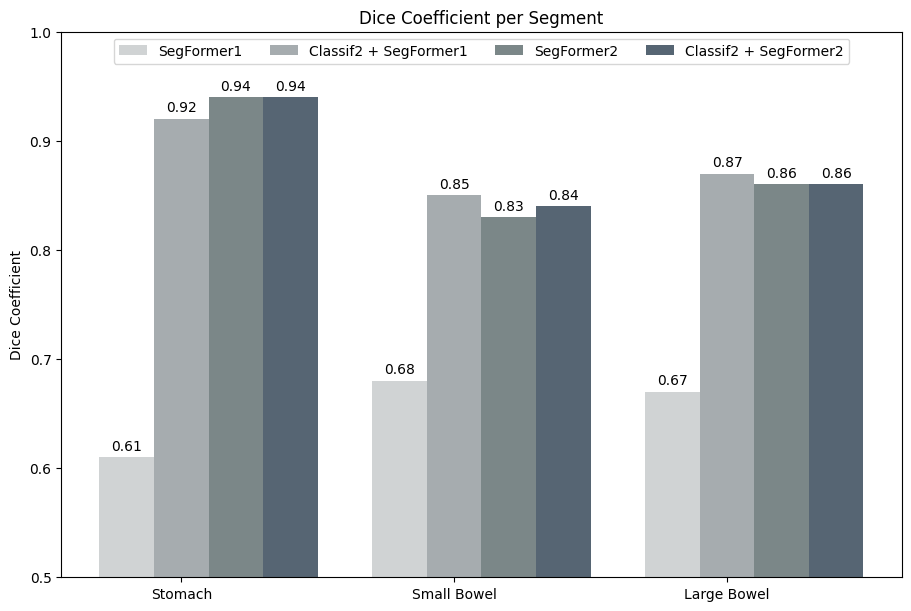

In [37]:
organs = ("Stomach", "Small Bowel", "Large Bowel")
method = {
    'SegFormer1': (score_ave_per_class_1[1], score_ave_per_class_1[2], score_ave_per_class_1[3]),
    'Classif2 + SegFormer1': (score_ave_per_class_21[1], score_ave_per_class_21[2], score_ave_per_class_21[3]),
    'SegFormer2': (score_ave_per_class_2[1], score_ave_per_class_2[2], score_ave_per_class_2[3]),
    'Classif2 + SegFormer2': (score_ave_per_class_22[1], score_ave_per_class_22[2], score_ave_per_class_22[3]) 
}

x = np.arange(len(organs))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

# Custom color palette
#colors = ['#8B4513', '#CD853F', '#D2B48C', '#556B2F']
colors = ['#D0D3D4', '#A6ACAF', '#7B8788', '#566573']

fig, ax = plt.subplots(layout='constrained', figsize=[9,6])

for attribute, measurement, color in zip(method.keys(), method.values(), colors):
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(measurement,2), width, label=attribute, color=color)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Dice Coefficient')
ax.set_title('Dice Coefficient per Segment')
ax.set_xticks(x + width, organs)
ax.legend(loc='upper center', ncol=4)
ax.set_ylim(0.5, 1)
plt.savefig('images/dice_score_per_organ.png')
plt.show()

The figure above illustrates the Dice coefficient by class for four of the evaluated algorithms. It is evident that the Dice coefficient for the stomach exceeds 0.90, followed by the large intestine, and then the small intestine. Overall, the addition of the classification model to the pipeline results in effective detection of all three organs.

# Conclusions
After evaluating the six proposed models, it was found that incorporating any of the classification models significantly improves the Dice coefficient for the SegFormer1 model. This is because SegFormer1 was trained exclusively on non-segmented images. While SegFormer2 achieves a similar Dice coefficient to SegFormer1 when combined with ResNetClassifier1 (or 2), it exhibits a lower recall, corresponding to the Dice coefficient when evaluating only segmented images. Based on the results, the combination of ResNetClassifier2 and SegFormer1 emerges as the most effective workflow, yielding the best results.

Therefore, the finally selected models for the enhanced Deep Learning network are:
- resnet50v2_nn256_lr0001_relu_batch64_epoch30_v4.keras (aka classification_model.keras)
- ckpt_049-vloss_0.3115_vf1_0.9401_batch16.ckpt (aka segmentation_model.ckpt)

These models will be called as **classification_model.keras** and **checkpoint.ckpt**, respectively, in the web application.

In [34]:
import pickle

# Variables to save
variables_to_save = {
    "score_ave_per_class_1": score_ave_per_class_1,
    "score_ave_per_class_2_1": score_ave_per_class_2_1,
    "time_per_image_1": time_per_image_1,
    "score_ave_per_class_2": score_ave_per_class_2,
    "score_ave_per_class_2_2": score_ave_per_class_2_2,
    "time_per_image_2": time_per_image_2,
    "score_ave_per_class_11": score_ave_per_class_11,
    "score_ave_per_class_2_11": score_ave_per_class_2_11,
    "time_per_image_11": time_per_image_11,
    "score_ave_per_class_21": score_ave_per_class_21,
    "score_ave_per_class_2_21": score_ave_per_class_2_21,
    "time_per_image_21": time_per_image_21,
    "score_ave_per_class_22": score_ave_per_class_22,
    "score_ave_per_class_2_22": score_ave_per_class_2_22,
    "time_per_image_22": time_per_image_22,
}

# Specify the file path
file_path = 'models/model_evaluation_variables.pkl'

# Save variables to a file
with open(file_path, 'wb') as f:
    pickle.dump(variables_to_save, f)

In [35]:
# Specify the file path

#file_path = 'models/model_evaluation_variables.pkl'

# Load variables from the file
#with open(file_path, 'rb') as f:
#    loaded_variables = pickle.load(f)

# Access the loaded variables
#score_ave_per_class_1 = loaded_variables["score_ave_per_class_1"]
#score_ave_per_class_2_1 = loaded_variables["score_ave_per_class_2_1"]
#time_per_image_1 = loaded_variables["time_per_image_1"]
#score_ave_per_class_2 = loaded_variables["score_ave_per_class_2"]
#score_ave_per_class_2_2 = loaded_variables["score_ave_per_class_2_2"]
#time_per_image_2 = loaded_variables["time_per_image_2"]
#score_ave_per_class_11 = loaded_variables["score_ave_per_class_11"]
#score_ave_per_class_2_11 = loaded_variables["score_ave_per_class_2_11"]
#time_per_image_11 = loaded_variables["time_per_image_11"]
#score_ave_per_class_21 = loaded_variables["score_ave_per_class_21"]
#score_ave_per_class_2_21 = loaded_variables["score_ave_per_class_2_21"]
#time_per_image_21 = loaded_variables["time_per_image_21"]
#score_ave_per_class_22 = loaded_variables["score_ave_per_class_22"]
#score_ave_per_class_2_22 = loaded_variables["score_ave_per_class_2_22"]
#time_per_image_22 = loaded_variables["time_per_image_22"]